In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import torch.nn as nn
import torch


from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC, F1Score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from mlp_model import JetParticleDataset_mlp, MLP_Adjustable
from utils import count_parameters, plot_metrics, plot_ROC, calculate_rocs

from time import time
import gc

In [3]:
print('Preparing data...')
start = time()
        
N = 16         
reverse = ''#'_reversed'
file_path = f'/home/asugu/work/event_data_tt_pad{N}_4mom{reverse}.pkl'

from_checkpoint = True
checkpoint_path = '/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_MLP_121.pth'

with open(file_path, 'rb') as file:
    event_data = pickle.load(file)
    
df = pd.DataFrame(event_data)

del event_data
gc.collect()


Preparing data...


20

In [4]:


device =  torch.device("cuda:1" if torch.cuda.is_available() else "cpu")  #"mps" if torch.backends.mps.is_available() else "cpu"  
print(device)

batch_size = 2048
n_epochs = 10
learning_rate = 0.001

in_features = 11
out_features = 1
hidden_units = 24
sparsity = 0.3


cuda:1


In [5]:

model = MLP_Adjustable(input_size=(in_features*N), output_size=1, n_hidden_layers = 4, nnodes=256)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

if from_checkpoint == True:

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    epoch_train_loss = checkpoint['train_losses']
    epoch_train_accuracy = checkpoint['train_accuracies']
    epoch_train_auc = checkpoint['train_aucs']
    epoch_train_f1 = checkpoint['train_f1s']
    epoch_val_loss = checkpoint['val_losses']
    epoch_val_accuracy = checkpoint['val_accuracies']
    epoch_val_auc = checkpoint['val_aucs']
    epoch_val_f1 = checkpoint['val_f1s']
    scaler_mean = np.array([-0.125])#checkpoint['scaler_mean']
    scaler_std = np.array([0.59947894])#checkpoint['scaler_std']
    scaler=(scaler_mean, scaler_std) 

    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

else:
    epoch = 0 
    epoch_train_loss = []
    epoch_train_accuracy = []
    epoch_train_auc = []
    epoch_train_f1 = []
    epoch_val_loss = []
    epoch_val_accuracy = []
    epoch_val_auc = []
    epoch_val_f1 = []
    scaler_mean = np.array([-0.125])
    scaler_std = np.array([0.59947894])
    scaler=(scaler_mean, scaler_std) 
    #scaler = StandardScaler()
model.to(device)

count_parameters(model)



#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

print("scalr is :", scaler)


+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| hidden_layers.0.weight |   65536    |
|  hidden_layers.0.bias  |    256     |
| hidden_layers.1.weight |   65536    |
|  hidden_layers.1.bias  |    256     |
| hidden_layers.2.weight |   65536    |
|  hidden_layers.2.bias  |    256     |
| hidden_layers.3.weight |   65536    |
|  hidden_layers.3.bias  |    256     |
|     layer1.weight      |   45056    |
|      layer1.bias       |    256     |
|    layerfin.weight     |    256     |
|     layerfin.bias      |     1      |
+------------------------+------------+
Total Trainable Params: 308737
scalr is : (array([-0.125]), array([0.59947894]))


In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['btag'])


train_dataset = JetParticleDataset_mlp(train_df, device=device, eval=False,scaler=scaler)
test_dataset = JetParticleDataset_mlp(test_df, device=device, eval=True,scaler=scaler)

print(len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)      # add workers
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=True)    

print(len(test_dataloader))


1149988
1


In [7]:
del df, train_df, test_df, train_dataset, test_dataset
gc.collect()

finish = time()

print(f"Data preperation took {finish-start} seconds.")

Data preperation took 89.35825514793396 seconds.


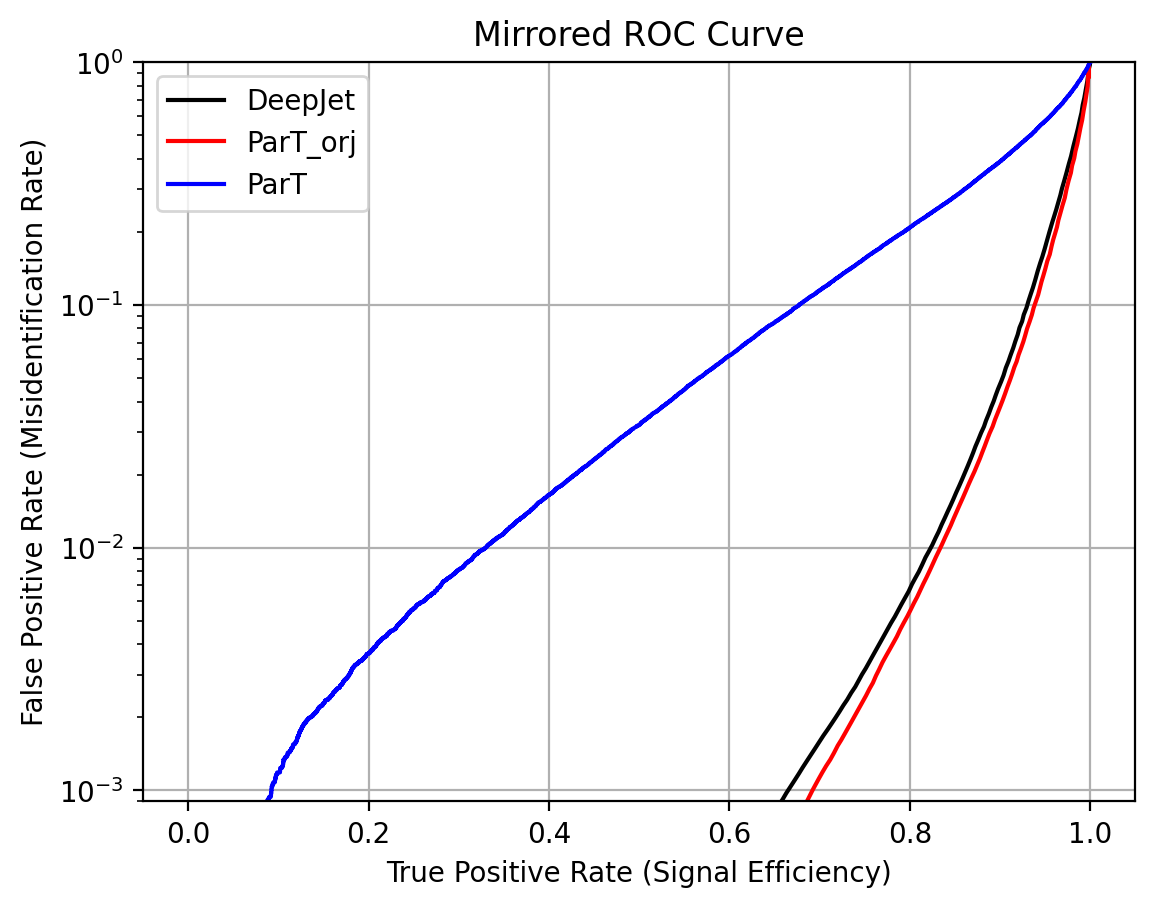

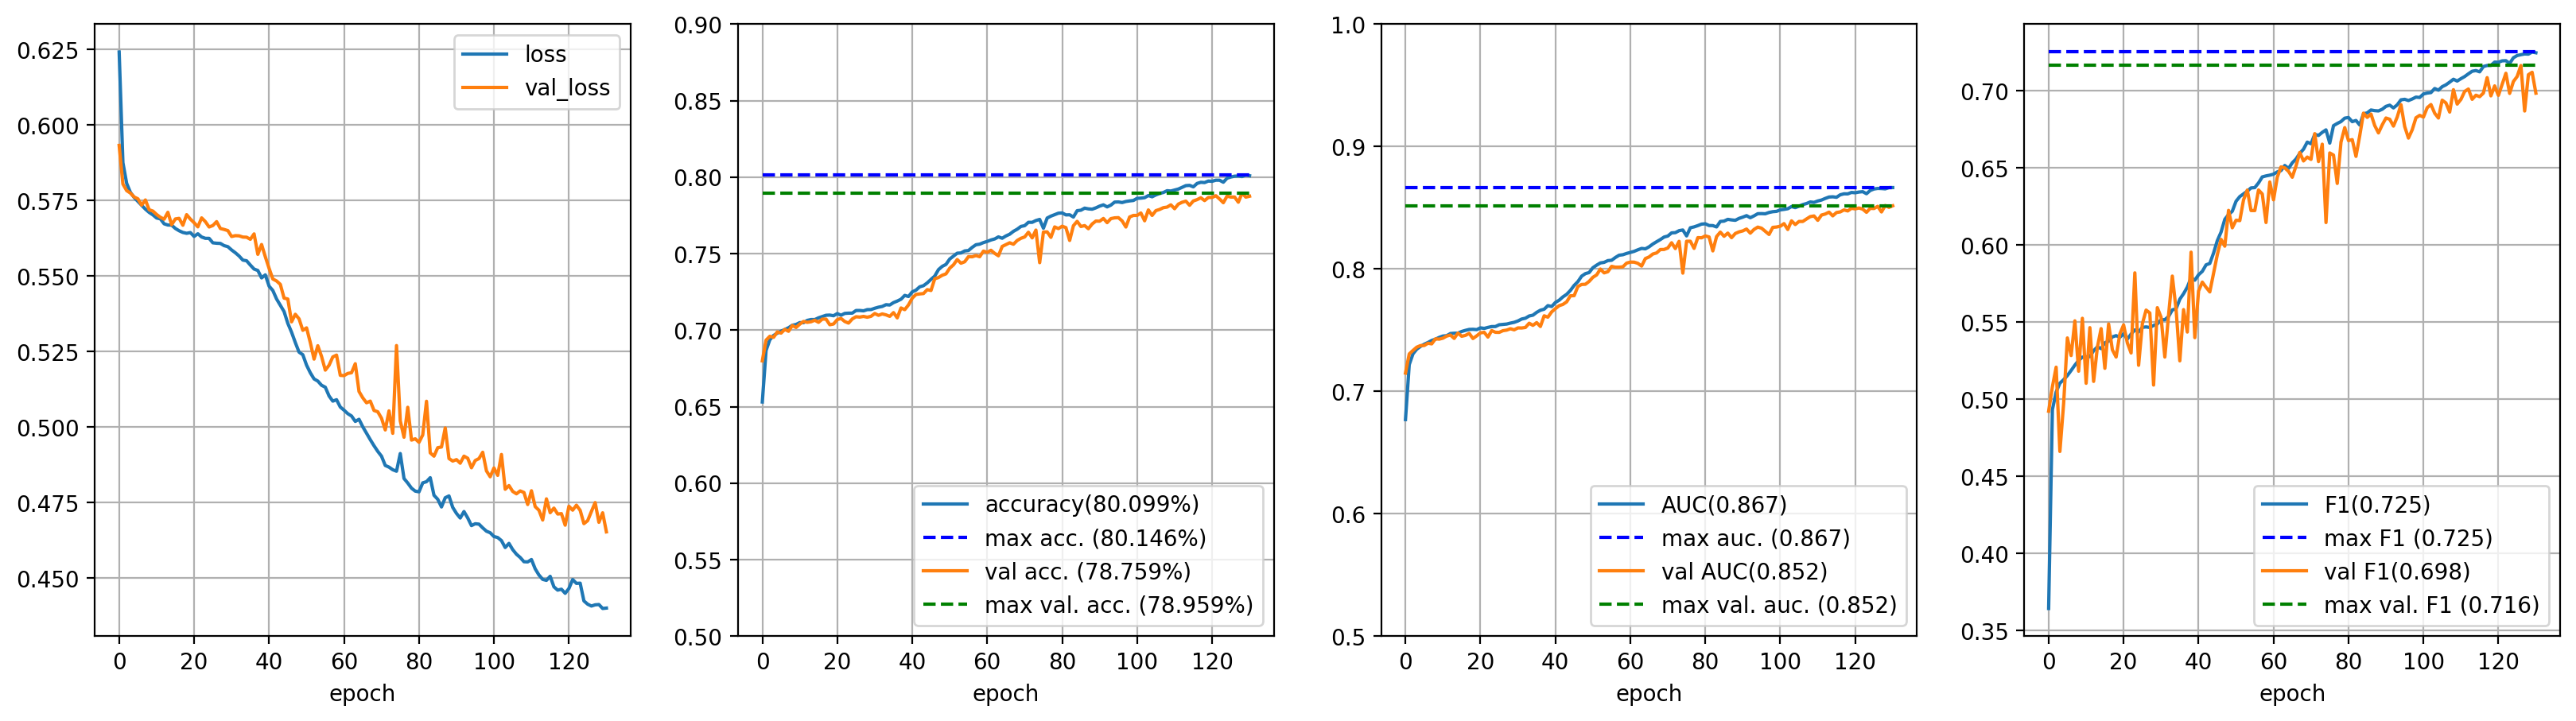

Training: Epoch [131/131] --- Loss: 0.4400 --- Accuracy: 0.8010 --- AUC: 0.867
Test    : Epoch [131/131] --- Loss: 0.4652 --- Accuracy: 0.7876 --- AUC: 0.852


In [8]:

acc_metric = BinaryAccuracy().to(device)
auc_metric = AUROC(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)


model.to(device)


for i_epoch in range(n_epochs):

    train_losses = []
    train_accuracies = []
    train_aucs = []
    train_f1s =[]
    val_losses = []
    val_accuracies = []
    val_aucs = []
    val_f1s = []




    lr = optimizer.param_groups[0]['lr']
    print(f'Learning rate was set to {lr:.5f}.')

    model.train()
    for batch_particle_inputs, batch_labels, _ in tqdm(train_dataloader): 
        
        particle_inputs = batch_particle_inputs.transpose(1,2)#.to(device)
        train_label = batch_labels#.to(device)

        optimizer.zero_grad()
        train_pred = model(particle_inputs)
        train_pred = train_pred.squeeze()
      
        loss = criterion(train_pred, train_label)

        if not torch.isnan(loss):  
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())
        train_accuracy = acc_metric(train_pred, train_label)
        train_accuracies.append(train_accuracy.item())
        train_auc = auc_metric(train_pred, train_label)
        train_aucs.append(train_auc.item())
        train_f1 = f1_metric(train_pred, train_label)
        train_f1s.append(train_f1.item())

   
    
    #scheduler.step()

    print('Evaluating metrics...', end='\r')

    model.eval()
    with torch.no_grad():
        for val_particle_inputs, val_labels, flavors in test_dataloader: 

            val_particle_inputs = val_particle_inputs.transpose(1,2)
            val_preds = model(val_particle_inputs)
            val_preds = val_preds.squeeze()

            val_loss = criterion(val_preds, val_labels)   
            val_losses.append(val_loss.item())
            val_accuracy = acc_metric(val_preds, val_labels)
            val_accuracies.append(val_accuracy.item())
            val_auc = auc_metric(val_preds, val_labels)
            val_aucs.append(val_auc.item())
            val_f1 = f1_metric(val_preds,val_labels)
            val_f1s.append(val_f1.item())
        
            _,_,l_fpr, l_tpr = calculate_rocs(val_preds, val_labels, flavors)
       
    plot_ROC(l_fpr.cpu().numpy(),l_tpr.cpu().numpy(),save_path=f'/home/asugu/work/part/roc_graphs/roc_{i_epoch}')

    epoch_val_loss.append(sum(val_losses) / len(val_losses))
    epoch_val_accuracy.append(sum(val_accuracies) / len(val_accuracies))
    epoch_val_auc.append(sum(val_aucs) / len(val_aucs))
    epoch_val_f1.append(sum(val_f1s) / len(val_f1s))
             
    epoch_train_loss.append( sum(train_losses) / len(train_losses))
    epoch_train_accuracy.append(sum(train_accuracies) / len(train_accuracies))
    epoch_train_auc.append(sum(train_aucs) / len(train_aucs))
    epoch_train_f1.append(sum(train_f1s) / len(train_f1s))
 
    plot_metrics(np.arange(i_epoch+epoch+1), epoch_train_loss, epoch_val_loss, epoch_train_accuracy, epoch_val_accuracy, epoch_train_auc, epoch_val_auc, epoch_train_f1, epoch_val_f1)

    print('Evaluating metrics finished!', end='\r')
    print(f'Training: Epoch [{i_epoch+epoch + 1}/{n_epochs+epoch}] --- Loss: {epoch_train_loss[-1]:.4f} --- Accuracy: {epoch_train_accuracy[-1]:.4f} --- AUC: {epoch_train_auc[-1]:.3f}\nTest    : Epoch [{i_epoch +epoch + 1}/{n_epochs+epoch}] --- Loss: {epoch_val_loss[-1]:.4f} --- Accuracy: {epoch_val_accuracy[-1]:.4f} --- AUC: {epoch_val_auc[-1]:.3f}\n', end='\r')
    
    torch.cuda.empty_cache()
    del loss, val_loss, train_pred, val_preds
    del train_losses, train_accuracies, train_aucs, train_f1s, val_losses, val_accuracies, val_aucs, val_f1s
    gc.collect()

#keys = ['train_losses', 'train_accuracies', 'train_aucs', 'val_losses', 'val_accuracies', 'val_aucs']
#values = [train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs]
#dict_metrics = {keys[i]: values[i] for i in range(len(keys))}

In [9]:
# Save model checkpoint
checkpoint = {
    'epoch': i_epoch + epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': epoch_train_loss,
    'train_accuracies': epoch_train_accuracy,
    'train_aucs': epoch_train_auc,
    'train_f1s': epoch_train_f1,
    'val_losses': epoch_val_loss,
    'val_accuracies': epoch_val_accuracy,
    'val_aucs': epoch_val_auc,
    'val_f1s': epoch_val_f1,

}

checkpoint_path = f'/home/asugu/work/part/LNN/checkpoints/model_checkpoint_tt_MLP_{i_epoch+epoch+1}.pth'
torch.save(checkpoint, checkpoint_path)


In [10]:
print(i_epoch+epoch+1)

131


In [11]:
"""
column_names = ['tpr', 'fpr']
pr = pd.DataFrame({'tpr': l_tpr.cpu(), 'fpr': l_fpr.cpu()})

# Define the file path for saving
output_path = '/home/asugu/work/benchmark/mlp_bench.csv'

# Save the DataFrame to a CSV file with specified column names
pr.to_csv(output_path, index=False)

"""

"\ncolumn_names = ['tpr', 'fpr']\npr = pd.DataFrame({'tpr': l_tpr.cpu(), 'fpr': l_fpr.cpu()})\n\n# Define the file path for saving\noutput_path = '/home/asugu/work/benchmark/mlp_bench.csv'\n\n# Save the DataFrame to a CSV file with specified column names\npr.to_csv(output_path, index=False)\n\n"